# Python Exam (Master, 08/11/2019): electric pulse analysis

> + **Allocated time:** 1h30
> + **Send your final notebook** at the end of the exam at [romain.madar@cern.ch](mailto:romain.madar@cern.ch) and [lennart.rustige@cern.ch](mailto:lennart.rustige@cern.ch)
> + **Allowed documents:** documentation of [python](https://docs.python.org/3/), [numpy](https://numpy.org/devdocs/user/index.html), [matplotlib](https://matplotlib.org/contents.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/) and [scipy](https://docs.scipy.org/doc/scipy/reference/) as well as the documentation from the notebook interface using `Shift+tab` keyboard shortcut, `help(module)` or `help(function)`.
> 
> The final mark will be a number between 0 (very bad) and 10 (very good). The evaluation of this exam takes into account mainly the correctness of the answers, but also the clarity of the explanations and the quality of the code. *There is no required knowledge about particle physics, detectors, ATLAS or CERN to answer the questions asked in this exam.*

## General informations

### A bit of context ...

In any physics experiment, detectors are used to quantitatively measure the studied phenomena, by delivering (in almost any case) an electric signal that can be later processed and analyzed. The playground for this exam is an example of a basic electric signal analysis, where the actual pulse comes from a light-to-current converter (as known as *photo-multiplier*) used in one of the particle detector, called ATLAS, recording proton-proton collisions which are performed in the Large Hadron Collider (LHC) at CERN. 

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Disable some warning due to the tool evolution
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

### Import data

The data are loaded into a pandas dataframe `df` using a `csv` file which were produced by a scope during a real measurement campaign. Two columns are available: the time value called `T` (in Second) and the voltage value called `V` (in Volt). The following cell load the dataframe and print the first 10 values.

In [2]:
# Skip the first 15 lines, rename the column and specify the type of data (float)
filePath = 'pulse.csv'
df = pd.read_csv(filePath, skiprows=15, names=['T', 'V'], dtype=np.float64)

# Display the first 10 rows
df.head(10)

,T,V
0,-4.000000e-08,-0.437750
1,-3.960000e-08,-0.437547
2,-3.920000e-08,-0.437109
3,-3.880000e-08,-0.437016
4,-3.840000e-08,-0.436938
5,-3.800000e-08,-0.436781
6,-3.760000e-08,-0.436422
7,-3.720000e-08,-0.437000
8,-3.680000e-08,-0.437750
9,-3.640000e-08,-0.439312


## 1. Plot the pulse `V(t)` (1 pts)

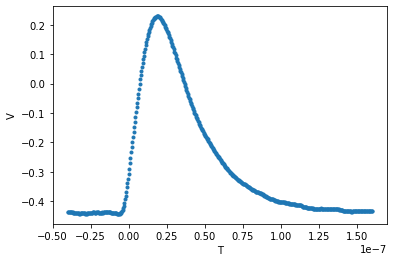

In [4]:
plt.figure()
plt.plot(df['T'], df['V'], '.')
plt.xlabel('T')
plt.ylabel('V');

## 2. Transforming the pulse (6 pts)

### 2. a) Add a column to `df` containing the time in ns, called `Tns`. Plot the result (1 pts)

In [5]:
df['Tns'] = df['T'] * 1e9
df.head(10)

,T,V,Tns
0,-4.000000e-08,-0.437750,-40.0
1,-3.960000e-08,-0.437547,-39.6
2,-3.920000e-08,-0.437109,-39.2
3,-3.880000e-08,-0.437016,-38.8
4,-3.840000e-08,-0.436938,-38.4
5,-3.800000e-08,-0.436781,-38.0
6,-3.760000e-08,-0.436422,-37.6
7,-3.720000e-08,-0.437000,-37.2
8,-3.680000e-08,-0.437750,-36.8
9,-3.640000e-08,-0.439312,-36.4


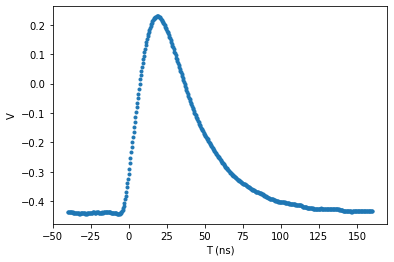

In [6]:
plt.figure()
plt.plot(df['Tns'], df['V'], '.')
plt.xlabel('T (ns)')
plt.ylabel('V');

### 2. b) What is the pedestal of the pulse, defined as the voltage value if no pulse were present ? (1 pts)

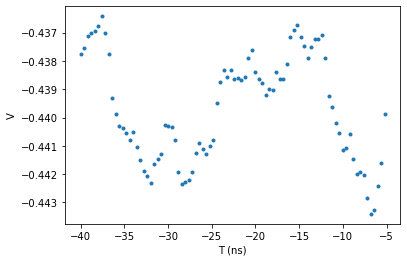

In [8]:
plt.figure()
plt.plot(df['Tns'][df.Tns<-5], df['V'][df.Tns<-5], '.')
plt.xlabel('T (ns)')
plt.ylabel('V');

In [10]:
ped = df['V'][df.Tns<-5].mean()
print(f'pedestal = {ped:.3f}')

pedestal = -0.440


### 2. c) Add a column to `df` containing the pedestal-substracted voltage, called `Vnorm`. Plot the result (1 pts)

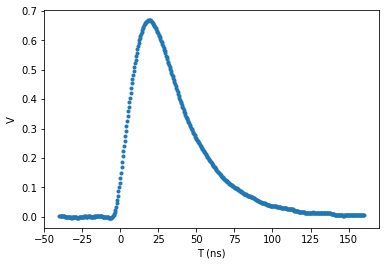

In [11]:
df['Vnorm'] = df['V'] - ped

plt.figure()
plt.plot(df.Tns, df.Vnorm, '.')
plt.xlabel('T (ns)')
plt.ylabel('V');

### 2. d) Normalize `Vnorm` to have a minumum of 0.0 and a maximum of 1.0. Plot the result (1 pts)

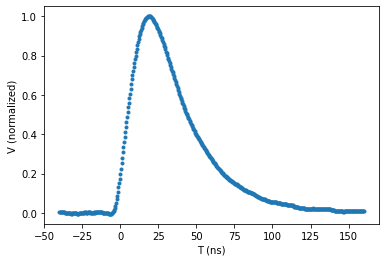

In [12]:
df.Vnorm = df.Vnorm / df.Vnorm.max()

plt.figure()
plt.plot(df.Tns, df.Vnorm, '.')
plt.xlabel('T (ns)')
plt.ylabel('V (normalized)');

### 2. e) Find `Tmax` which has the max amplitude (1 pts)
HINT: checkout `np.argmax()` function.

In [15]:
idmax = df.Vnorm.argmax()

Tmax = df['Tns'][idmax]

print(f'Tmax = {Tmax}')

Tmax = 18.8


### 2. f) Plot the transformed pulse satisfying `Tmax=0`, `Vmin=0` and `Vmax=1` (1 pts)

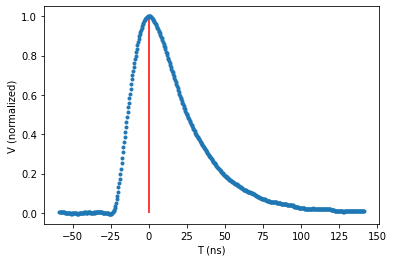

In [18]:
Ttrans = df.Tns - Tmax

plt.figure()
plt.plot(Ttrans, df.Vnorm, '.')
plt.vlines(0, 0, 1, colors='r')
plt.xlabel('T (ns)')
plt.ylabel('V (normalized)');

## 3. Pulse caracterization (3 pts)

### 3. a) Compute and plot the cumulative sum of the pulse (1 pts)

The cumulative sum is defined as $\mathcal{V}(t) = \sum_{\tau\leq t} V(\tau)$

HINT: checkout `np.cumsum()` function

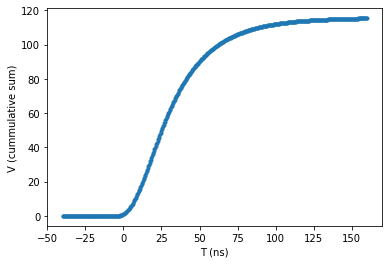

In [19]:
Vcumsum = df.Vnorm.cumsum()

plt.figure()
plt.plot(df.Tns, Vcumsum, '.')
plt.xlabel('T (ns)')
plt.ylabel('V (cummulative sum)');

### 3. b) Compute the full width of the pulse at its half maximum (2 pts)

This width is defined as $|t_1 - t_2|$ width $V(t_1)=V(t_2)=V_{\text{max}}/2$

In [20]:
Vm2 = df.Vnorm.max()/2

left = Ttrans < 0
mask = df.Vnorm[left] < Vm2
t1 = Ttrans[left][mask]
t1 = t1.max()

right = Ttrans > 0
mask = df.Vnorm[right] < Vm2
t2 = Ttrans[right][mask]
t2 = t2.min()

print(f't1 = {t1}')
print(f't2 = {t2}')
print(f'width = {np.abs(t1 - t2)}')

t1 = -14.400000000000002
t2 = 25.2
width = 39.6


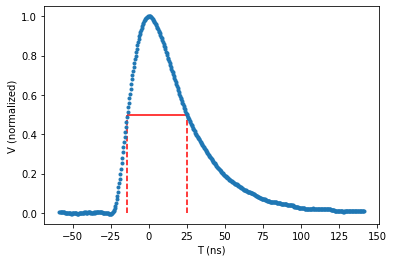

In [22]:
plt.figure()
plt.plot(Ttrans, df.Vnorm, '.')
plt.vlines([t1, t2], 0, Vm2, colors='r', linestyles='dashed')
plt.hlines(Vm2, t1, t2, colors='r')
plt.xlabel('T (ns)')
plt.ylabel('V (normalized)');

## Bonus question

### Perform a fit of the peak by a gaussian on the time window $[-10, 10]$ ns and plot the result.

Reminder: a gaussian function of amplitude $A$, average $\mu$ and width $\sigma$ can be expressed as

$$
\mathcal{G}(x) = A \, \exp\left( -\frac{(x - \mu)^2}{2\sigma^2} \right)
$$

In [23]:
# The function to fit
def gaus(x, A, mu, sig):
    return A * np.exp(-(x - mu)**2 / (2 * sig**2))

In [24]:
Tfit = Ttrans[(Ttrans>-10) & (Ttrans<10)]
Vfit = df.Vnorm[(Ttrans>-10) & (Ttrans<10)]

par, cov = curve_fit(gaus, Tfit, Vfit)

print(f'A   = {par[0]}')
print(f'mu  = {par[1]}')
print(f'sig = {par[2]}')

A   = 1.0004778060793147
mu  = 0.805625048600355
sig = 14.870474622525784


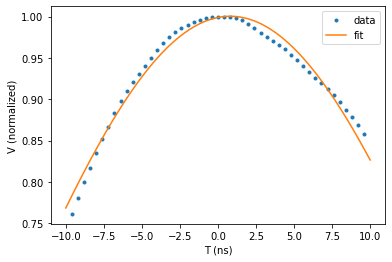

In [26]:
Tcont = np.linspace(-10,10,200)

plt.figure()
plt.plot(Tfit, Vfit, '.', label='data')
plt.plot(Tcont, gaus(Tcont, *par), label='fit')
plt.legend()
plt.xlabel('T (ns)')
plt.ylabel('V (normalized)');

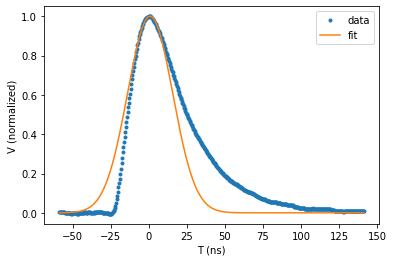

In [27]:
Tcont = np.linspace(Ttrans.min(),Ttrans.max(),1000)

plt.figure()
plt.plot(Ttrans, df.Vnorm, '.', label='data')
plt.plot(Tcont, gaus(Tcont, *par), label='fit')
plt.legend()
plt.xlabel('T (ns)')
plt.ylabel('V (normalized)');